In [1]:
ls()
rm(list = ls())

character(0)

In [26]:
library(data.table)
library(tidyverse)
library(dplyr)      
library(splines)    
library(splitTools) 
library(xgboost)    
library(keras)
library(ggplot2)

In [6]:
setwd("Desktop/Marcin Filip/Projects/Project 003 - ADS Pricing/Kaggle_data/")

input <- fread(input = "porto-seguro-safe-driver-prediction/train.csv")
input <- tibble(input)

exclude_cols <- c("ps_ind_09_bin", "ps_ind_14")
cols <- setdiff(names(input), exclude_cols)

input <- input[, cols]

In [11]:
x <- names(input[, c(-1, -2)])
y <- "target"
x <- setdiff(x, names(input)[str_sub(names(input), -3, -1) == "cat"])
input <- input[, c(x, y)]

In [12]:
head(input)

ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_15,⋯,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,5,0,1,0,0,0,0,0,11,⋯,1,5,8,0,1,1,0,0,1,0
1,7,0,0,1,0,0,0,0,3,⋯,1,1,9,0,1,1,0,1,0,0
5,9,0,0,1,0,0,0,0,12,⋯,2,7,7,0,1,1,0,1,0,0
0,2,1,0,0,0,0,0,0,8,⋯,2,4,9,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,9,⋯,1,1,3,0,0,0,1,1,0,0
5,4,0,0,0,0,0,0,0,6,⋯,2,0,9,0,1,0,1,1,1,0


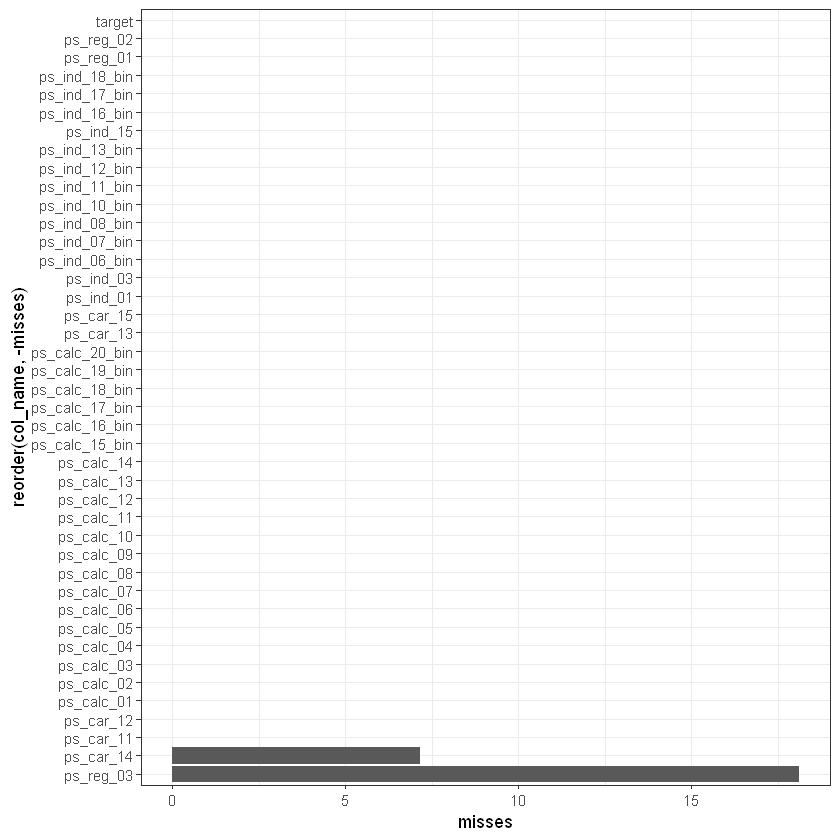

In [13]:
len_inp <- dim(input)[[1]]
missing_values_df <- data.frame(apply(input, 2, FUN = function(x) sum(x == -1)) / len_inp * 100)
missing_values_df <- tibble::rownames_to_column(missing_values_df, "col_name")
names(missing_values_df) <- c("col_name", "misses")
missing_values_df %>%
  ggplot(mapping = aes(x = reorder(col_name, - misses), y = misses)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  theme_bw()


In [14]:
smp_size <- floor(0.20 * nrow(input))
set.seed(123)
train_ind <- sample(seq_len(nrow(input)), size = smp_size)

train <- input[train_ind, ]
test <- input[-train_ind, ]

In [17]:
dim(train)
str(train)

[1] 119042     42

tibble [119,042 x 42] (S3: tbl_df/tbl/data.frame)
 $ ps_ind_01     : int [1:119042] 0 3 5 5 1 0 0 0 1 0 ...
 $ ps_ind_03     : int [1:119042] 2 2 6 11 2 3 1 0 7 3 ...
 $ ps_ind_06_bin : int [1:119042] 1 0 1 1 1 0 1 1 1 0 ...
 $ ps_ind_07_bin : int [1:119042] 0 0 0 0 0 0 0 0 0 1 ...
 $ ps_ind_08_bin : int [1:119042] 0 1 0 0 0 0 0 0 0 0 ...
 $ ps_ind_10_bin : int [1:119042] 0 0 0 0 0 0 0 0 0 0 ...
 $ ps_ind_11_bin : int [1:119042] 0 0 0 0 0 0 0 0 0 0 ...
 $ ps_ind_12_bin : int [1:119042] 0 0 0 0 0 0 0 0 0 0 ...
 $ ps_ind_13_bin : int [1:119042] 0 0 0 0 0 0 0 0 0 0 ...
 $ ps_ind_15     : int [1:119042] 5 1 7 13 10 7 7 7 7 7 ...
 $ ps_ind_16_bin : int [1:119042] 0 0 1 0 1 1 1 1 1 0 ...
 $ ps_ind_17_bin : int [1:119042] 0 0 0 0 0 0 0 0 0 1 ...
 $ ps_ind_18_bin : int [1:119042] 1 1 0 1 0 0 0 0 0 0 ...
 $ ps_reg_01     : num [1:119042] 0.8 0.7 0.1 0.4 0.6 0.9 0.7 0.9 0.6 0.9 ...
 $ ps_reg_02     : num [1:119042] 0.2 0.5 0.3 0 0.2 1.7 0.1 0.4 0.2 0.8 ...
 $ ps_reg_03     : num [1:119042] 0.603

In [18]:
### GLM

fit_glm <- glm(target ~ .,
               data = train,
               family = poisson())
summary(fit_glm)

In [107]:
### XGBoost

prep_xgb <- function(dat, x) {
  data.matrix(dat[, x, drop = FALSE])
}

# Data interface to XGBoost
dtrain <- xgb.DMatrix(prep_xgb(train, x), 
                      label = train[[y]]) 
                      # weight = train[[w]])

# Parameters chosen by 5-fold grouped CV
params_freq <- list(learning_rate = 0.2,
                    max_depth = 5,
                    alpha = 3,
                    lambda = 0.5,
                    max_delta_step = 2,
                    min_split_loss = 0,
                    #  monotone_constraints = c(0,-1,0,0,0,0,0), 
                    #  interaction_constraints = list(4, c(0, 1, 2, 3, 5, 6)),
                    colsample_bytree = 1,
                    subsample = 0.9)

# Fit
set.seed(1)
fit_xgb <- xgb.train(params_freq, 
                     data = dtrain,
                     nrounds = 500,
                     objective = "count:poisson",
                     watchlist = list(train = dtrain),
                     print_every_n = 10)

[1]	train-poisson-nloglik:0.514053 
[11]	train-poisson-nloglik:0.416197 
[21]	train-poisson-nloglik:0.343450 
[31]	train-poisson-nloglik:0.289620 
[41]	train-poisson-nloglik:0.250181 
[51]	train-poisson-nloglik:0.221510 
[61]	train-poisson-nloglik:0.200839 
[71]	train-poisson-nloglik:0.186142 
[81]	train-poisson-nloglik:0.175770 
[91]	train-poisson-nloglik:0.168537 
[101]	train-poisson-nloglik:0.163506 
[111]	train-poisson-nloglik:0.160031 
[121]	train-poisson-nloglik:0.157579 
[131]	train-poisson-nloglik:0.155882 
[141]	train-poisson-nloglik:0.154617 
[151]	train-poisson-nloglik:0.153708 
[161]	train-poisson-nloglik:0.152997 
[171]	train-poisson-nloglik:0.152421 
[181]	train-poisson-nloglik:0.151930 
[191]	train-poisson-nloglik:0.151513 
[201]	train-poisson-nloglik:0.151098 
[211]	train-poisson-nloglik:0.150728 
[221]	train-poisson-nloglik:0.150361 
[231]	train-poisson-nloglik:0.150011 
[241]	train-poisson-nloglik:0.149682 
[251]	train-poisson-nloglik:0.149345 
[261]	train-poisson-nlo

Model: "model"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense1 (InputLayer)                 [(None, 41)]                    0           
________________________________________________________________________________
dense (Dense)                       (None, 20)                      840         
________________________________________________________________________________
dense_1 (Dense)                     (None, 15)                      315         
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      160         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       11          
Total params: 1,326
Trainable params: 1,326
Non-trainable params: 0
__________________________

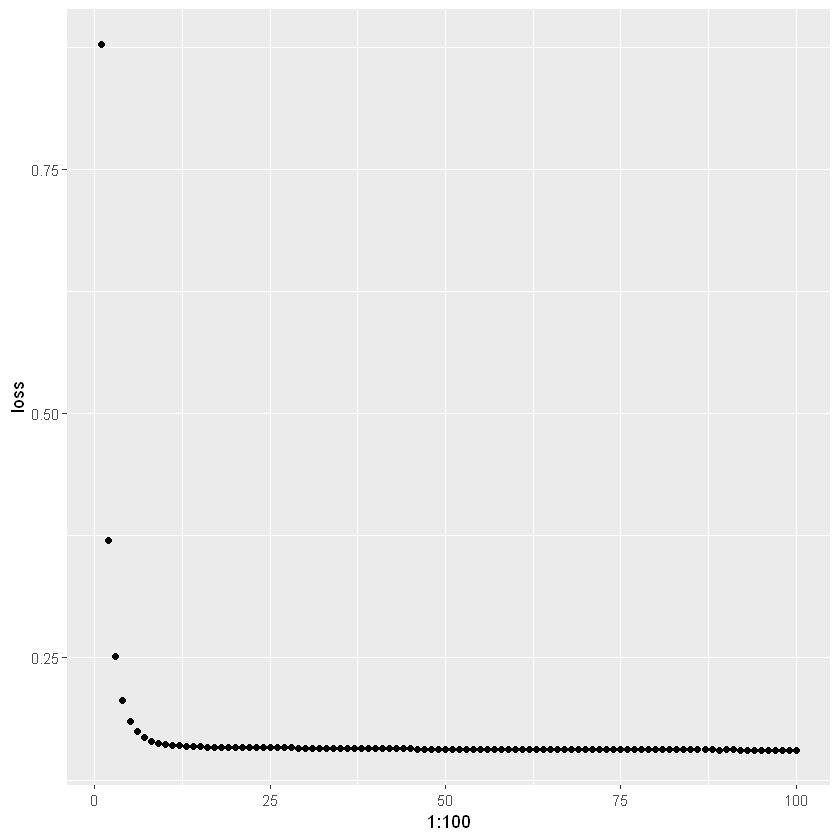

In [27]:
### NN

train <- as.data.frame(train)

# Input list maker
prep_nn <- function(dat, x) {
  dense_cols <- x
   c(list(dense1 = data.matrix(dat[, dense_cols], rownames.force = TRUE)))
}

# Initialize neural net
new_neural_net <- function() {
  k_clear_session()
  set.seed(1)
  if ("set_seed" %in% names(tensorflow::tf$random)) {
    tensorflow::tf$random$set_seed(0)
  } else if ("set_random_seed" %in% names(tensorflow::tf$random)) {
    tensorflow::tf$random$set_random_seed(0)
  } else {
    print("Check tf version")
  }
  
  # Model architecture
  dense_input <- layer_input(41, name = "dense1", dtype = "float32")
  outputs <- dense_input %>%  
    layer_dense(20, activation = "tanh") %>%
    layer_dense(15, activation = "tanh") %>%
    layer_dense(10, activation = "tanh") %>%
    layer_dense(1, activation = "exponential")
  
  inputs <- list(dense1 = dense_input)
    
  model <- keras_model(inputs, outputs)
  
  model %>% 
    compile(loss = loss_poisson,
            optimizer = optimizer_nadam(),
            weighted_metrics = "poisson")
  return(model)
}

neural_net <- new_neural_net()

neural_net %>% 
  summary()

history <- neural_net %>% 
  fit(x = prep_nn(train, x), 
      y = train[, y], 
      # sample_weight = train[, w],
      batch_size = 1e4, 
      epochs = 100,
      verbose = 2)  

ggplot(data.frame(history$metrics), mapping = aes(x = 1:100, y = loss)) + 
  geom_point()

# Calibrate by using last hidden layer activations as GLM input encoder
encoder <- keras_model(inputs = neural_net$input, 
                       outputs = get_layer(neural_net, "dense_2")$output)

# Creates input for calibration GLM (extends prep_nn)
prep_nn_calib <- function(dat, x, enc = encoder) {
  prep_nn(dat, x) %>% 
    predict(enc, ., batch_size = 1e4) %>% 
    data.frame()
}

# Calibration GLM
fit_nn <- glm(target ~ .,
              data = cbind(train["target"], prep_nn_calib(train, x)), 
              family = quasipoisson())#, 
              # weights = train[[w]])


In [110]:
### XAI

set.seed(1)

library(MetricsWeighted)  
library(flashlight)       
library(ggplot2)

In [111]:
fillc <- "#E69F00"

fl_glm <- flashlight(
  model = fit_glm, label = "GLM", 
  predict_function = function(fit, X) predict(fit, X, type = "response")
)

fl_xgb <- flashlight(
  model = fit_xgb, label = "XGBoost", 
  predict_function = function(fit, X) predict(fit, prep_xgb(X, x))
)


fl_nn <- flashlight(
  model = fit_nn, label = "NNet", 
  predict_function = function(fit, X) 
    predict(fit, prep_nn_calib(X, x), type = "response")
)


In [112]:
metrics <- list(`Average deviance` = deviance_poisson, 
                `Relative deviance reduction` = r_squared_poisson)

fls <- multiflashlight(list(fl_glm, fl_nn, fl_xgb), data = test, 
                       y = y, metrics = metrics)

fls_log <- multiflashlight(fls, linkinv = log)

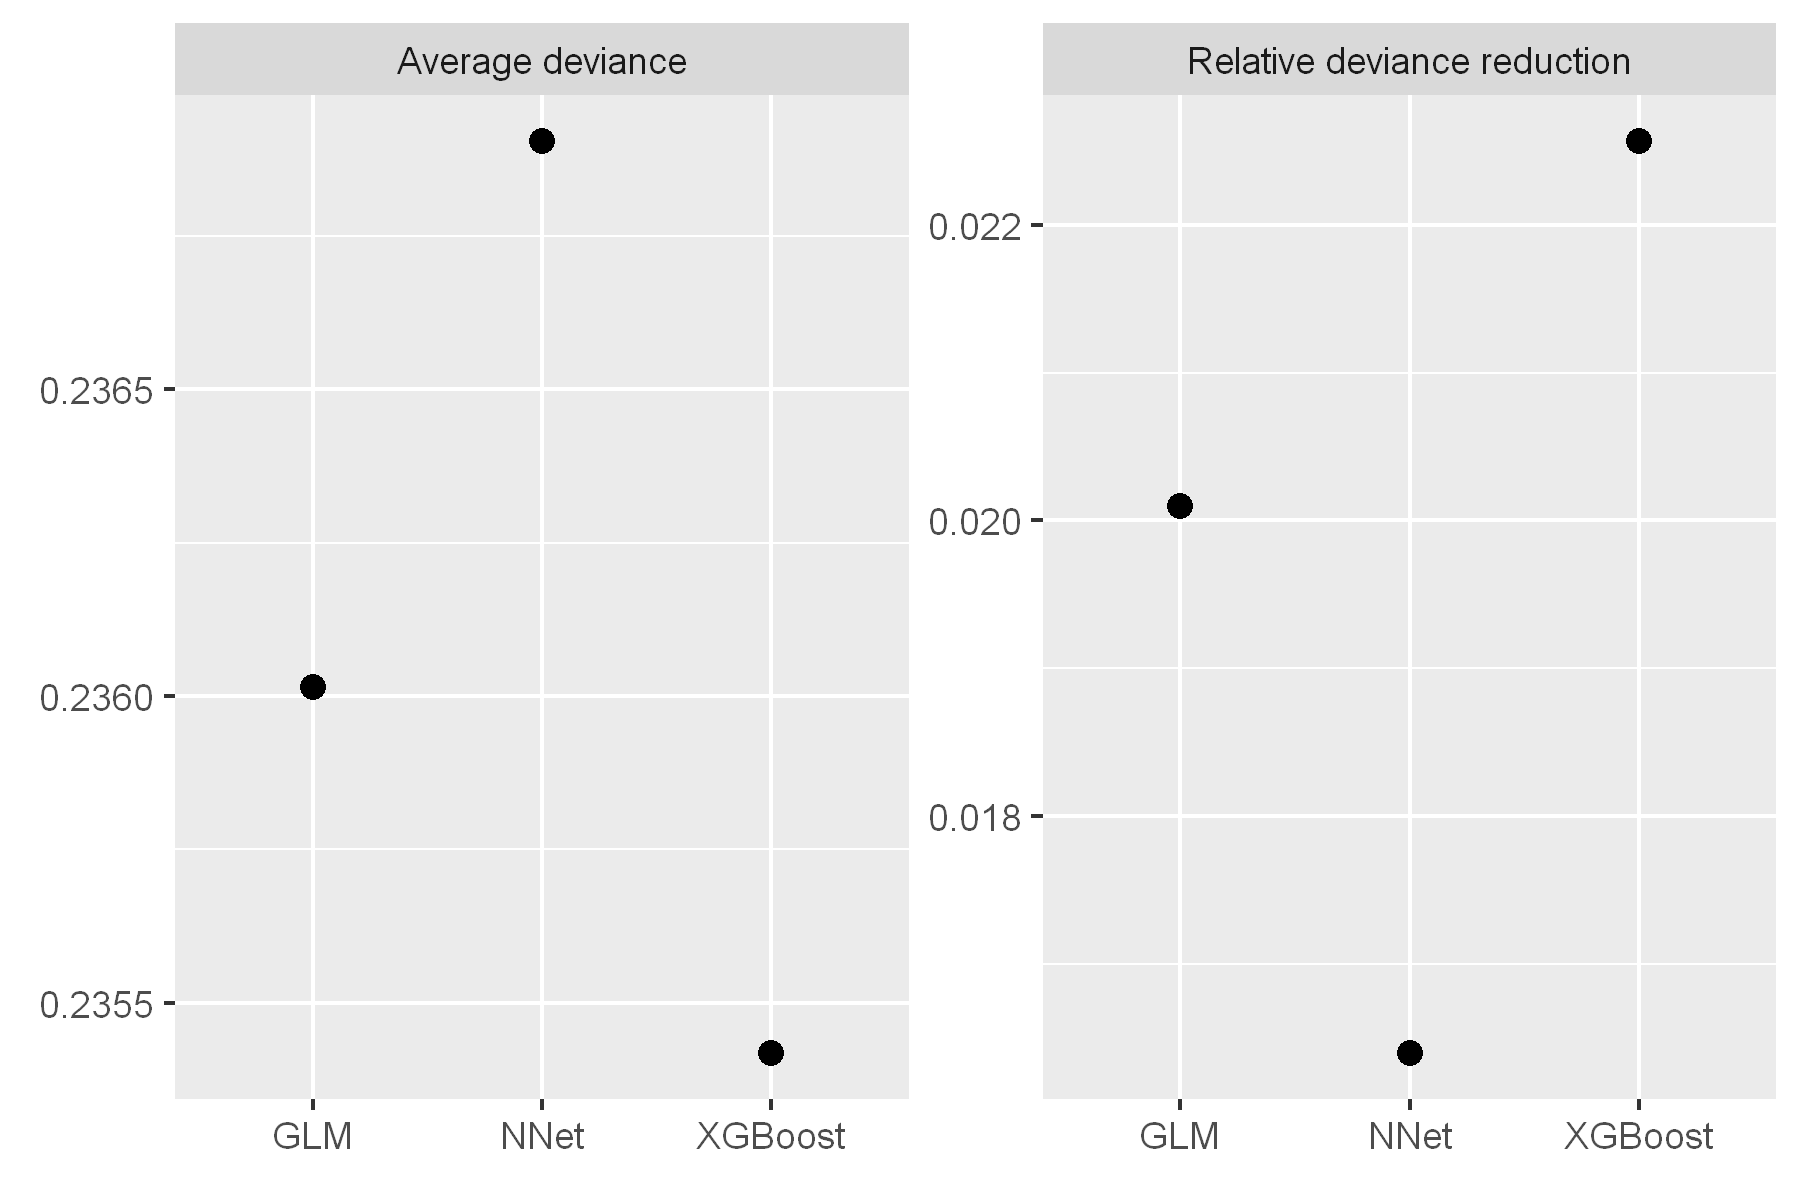

In [113]:
# ===============================================
# Performance
# ===============================================

library(repr)
options(repr.plot.width = 15, repr.plot.height = 10)
update_geom_defaults("point", list(size = 7))

perf <- light_performance(fls)
# perf
plot(perf, geom = "point") +
  labs(x = element_blank(), y = element_blank()) +
  theme_grey(base_size = 28)

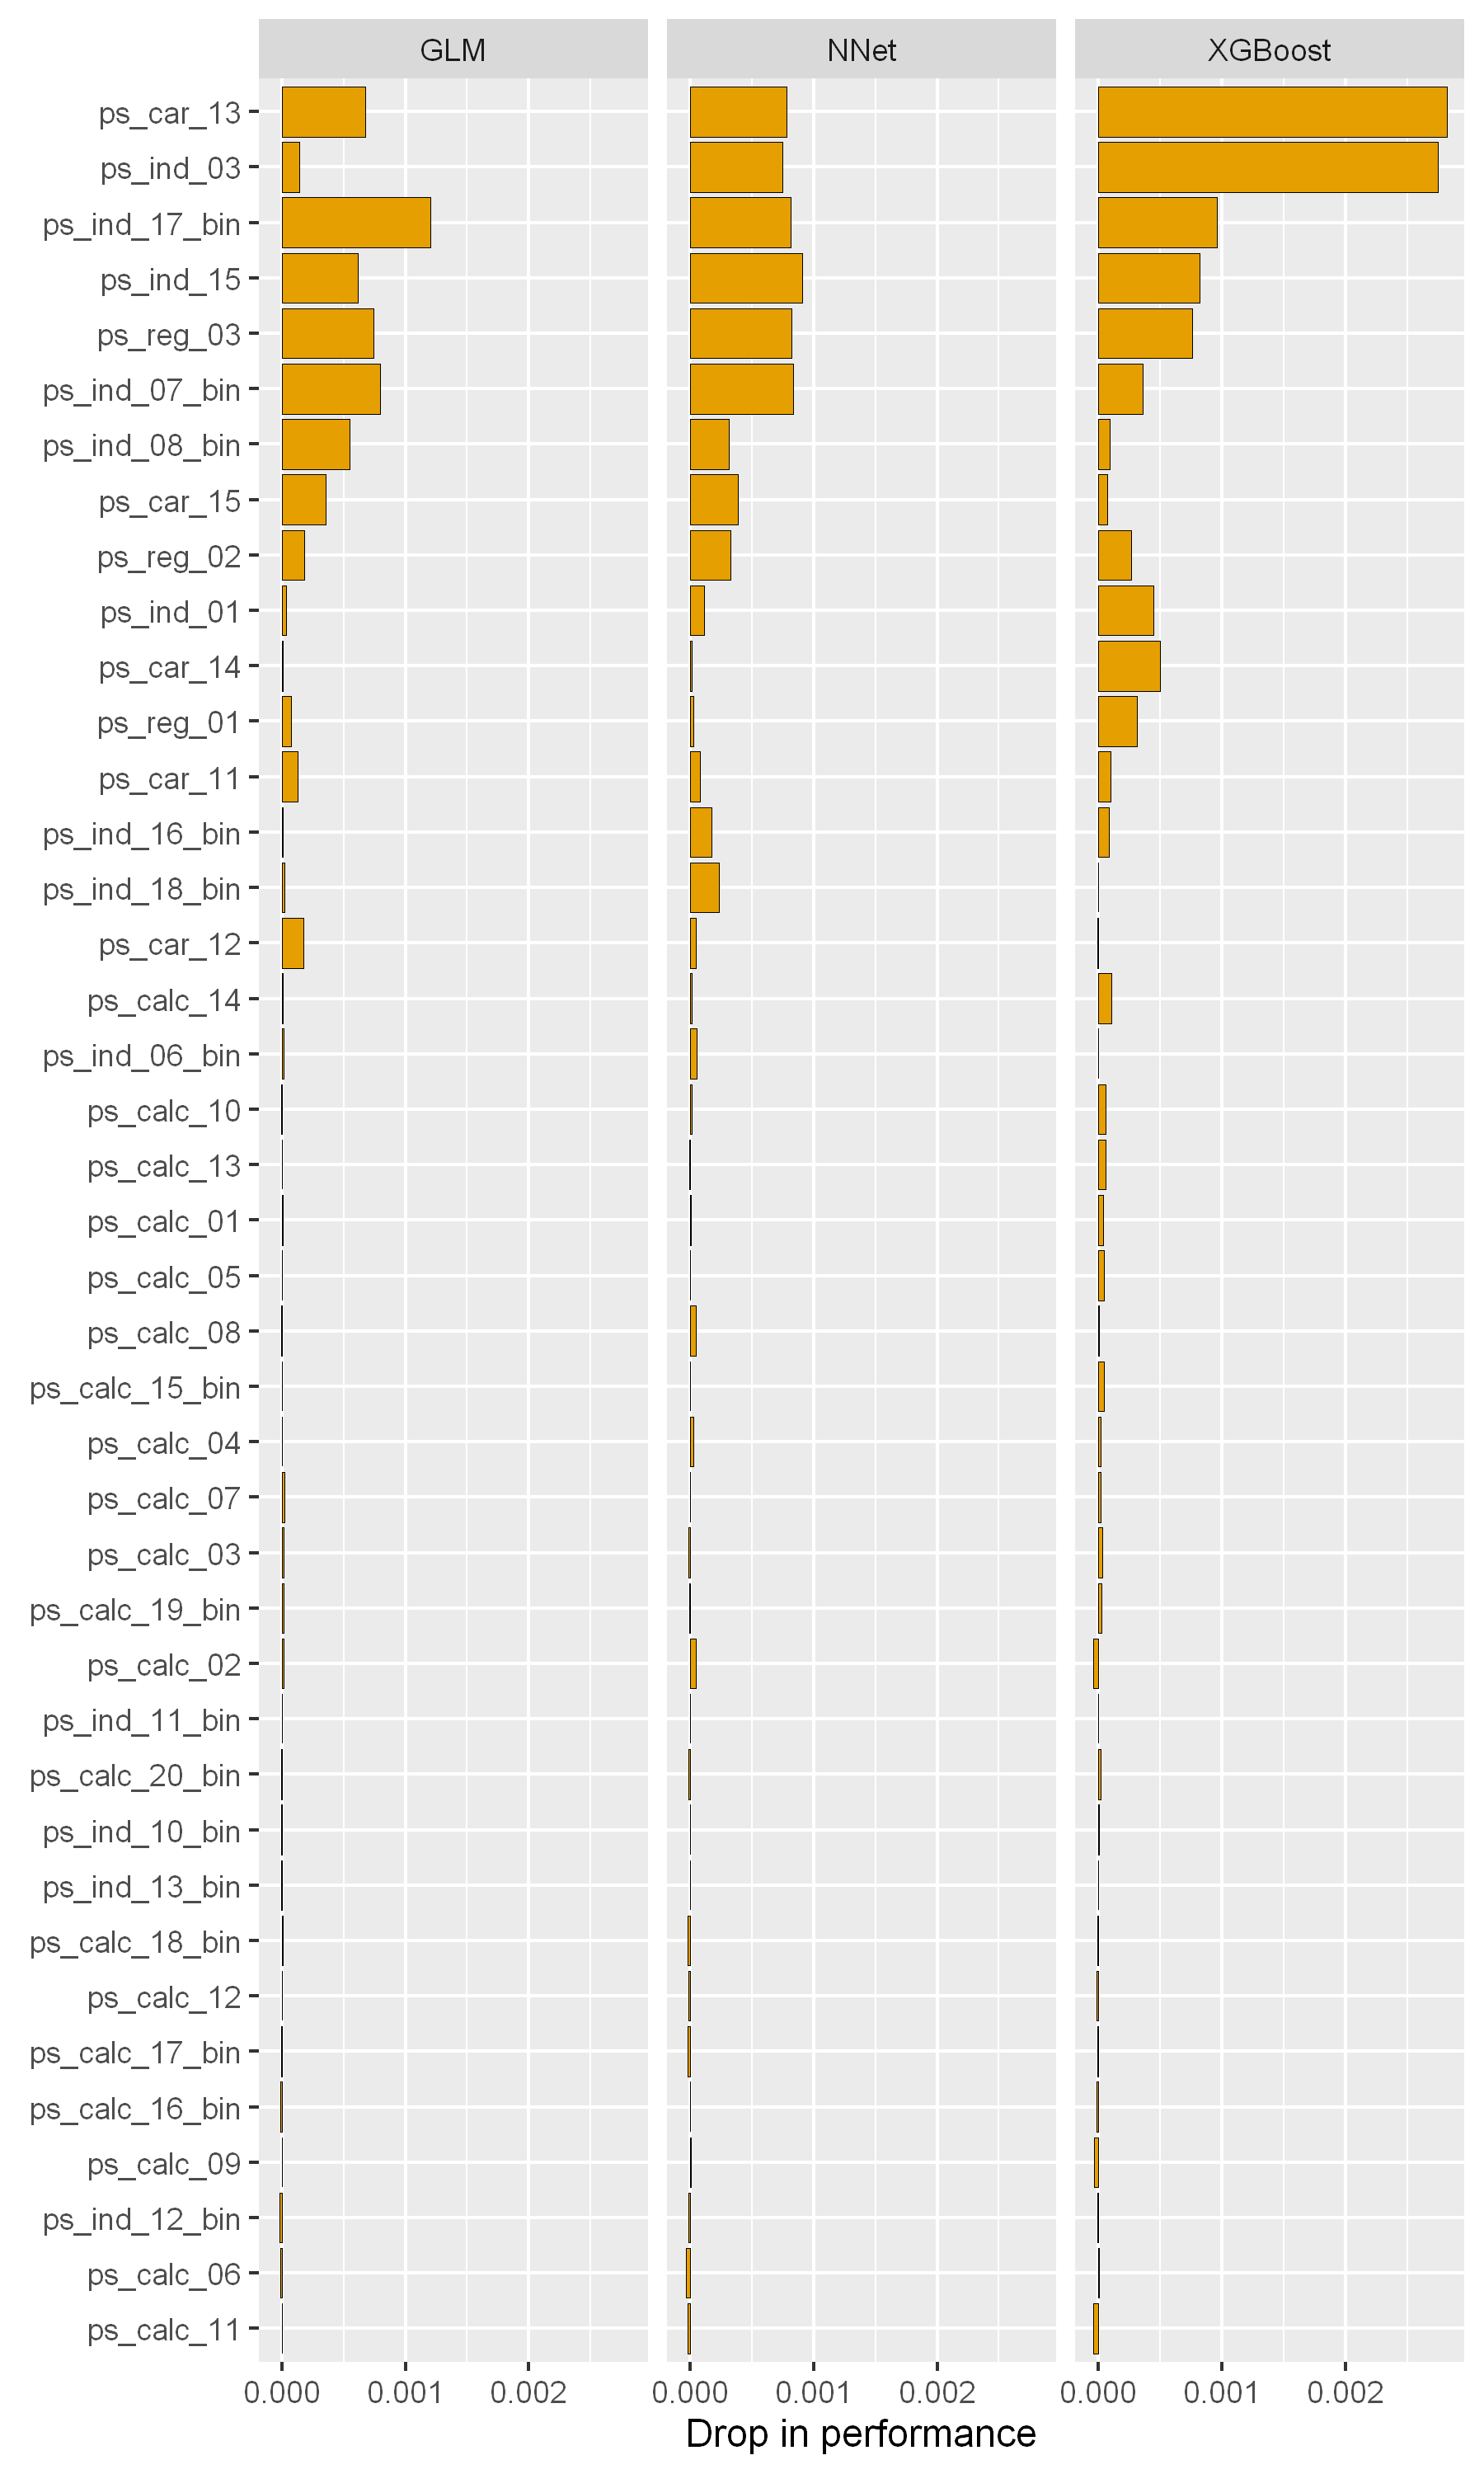

In [114]:
# ===============================================
# Importance
# ===============================================
imp <- light_importance(fls, v = x)

options(repr.plot.width = 15, repr.plot.height = 25)

plot(imp, fill = fillc, color = "black") +
  theme_grey(base_size = 28)
#   theme(axis.text = element_text(size = 12),
#   axis.title = element_text(size = 14, face = "bold"))

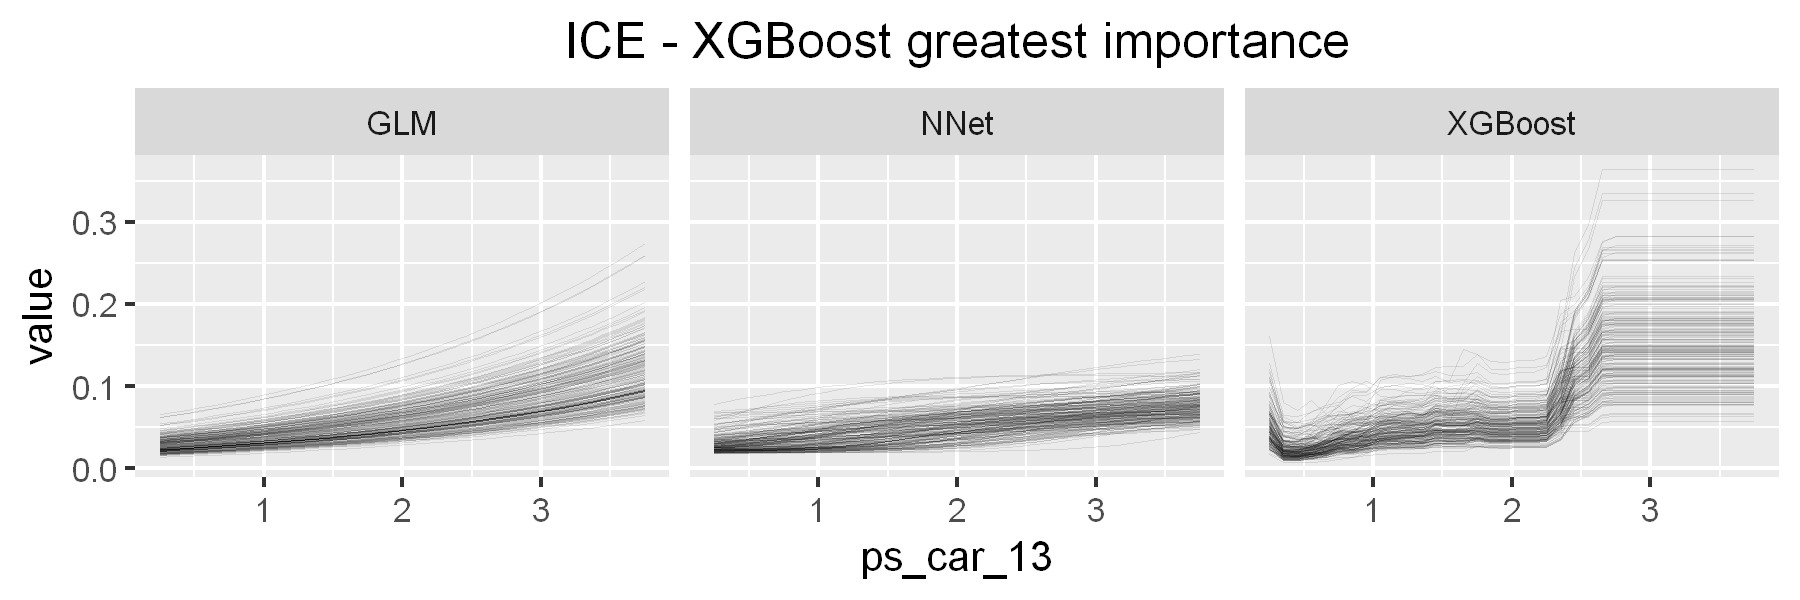

In [124]:
# ===============================================
# Effects
# ===============================================

options(repr.plot.width = 15, repr.plot.height = 5)

# ICE (uncentered and centered, without log and with)
plot(light_ice(fls, v = "ps_car_13", n_max = 200, seed = 3), alpha = 0.1) +
    theme_grey(base_size = 25) +
    ggtitle("ICE - XGBoost greatest importance") +
    theme(plot.title = element_text(hjust = 0.5))

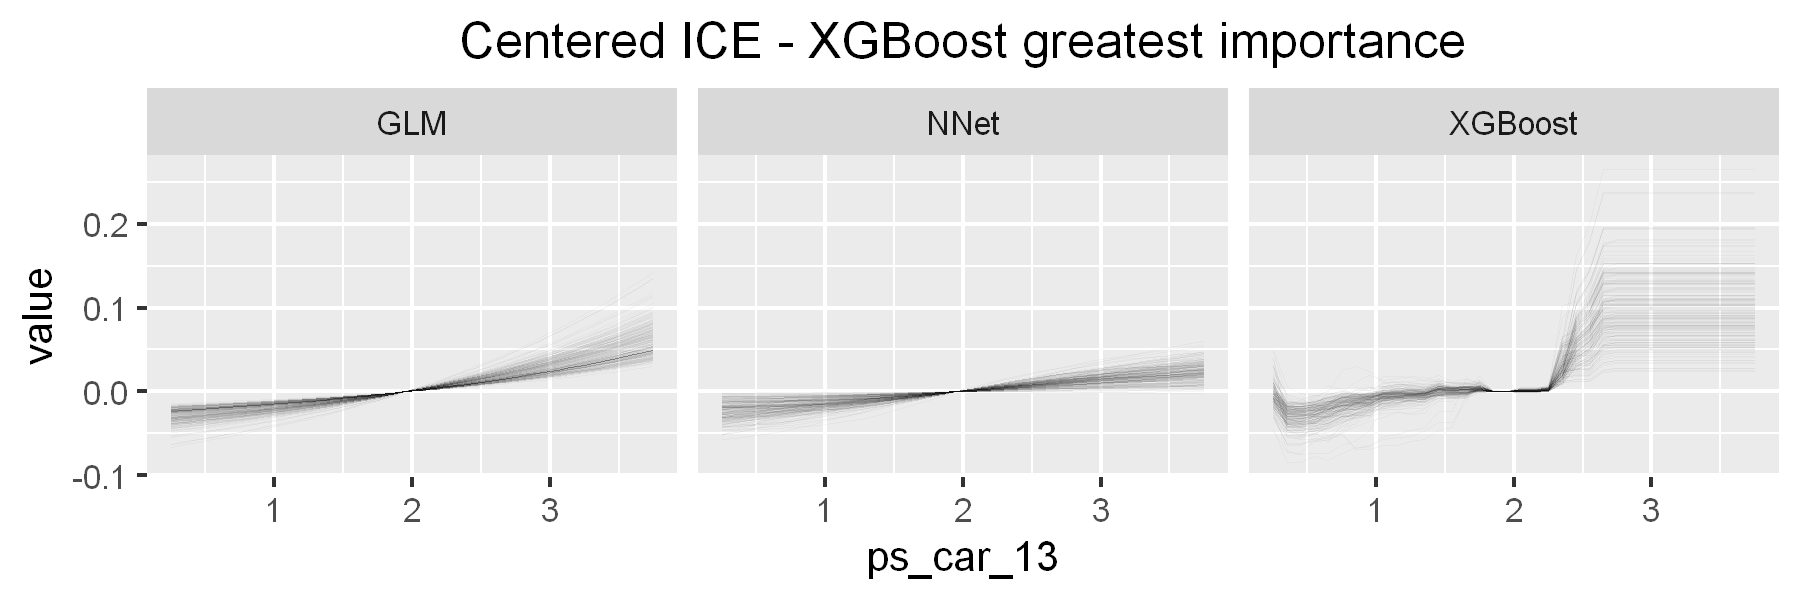

In [125]:
plot(light_ice(fls, v = "ps_car_13", n_max = 200, seed = 3, 
               center = "middle"), alpha = 0.03) +
    theme_grey(base_size = 25) +
    ggtitle("Centered ICE - XGBoost greatest importance") +
    theme(plot.title = element_text(hjust = 0.5))

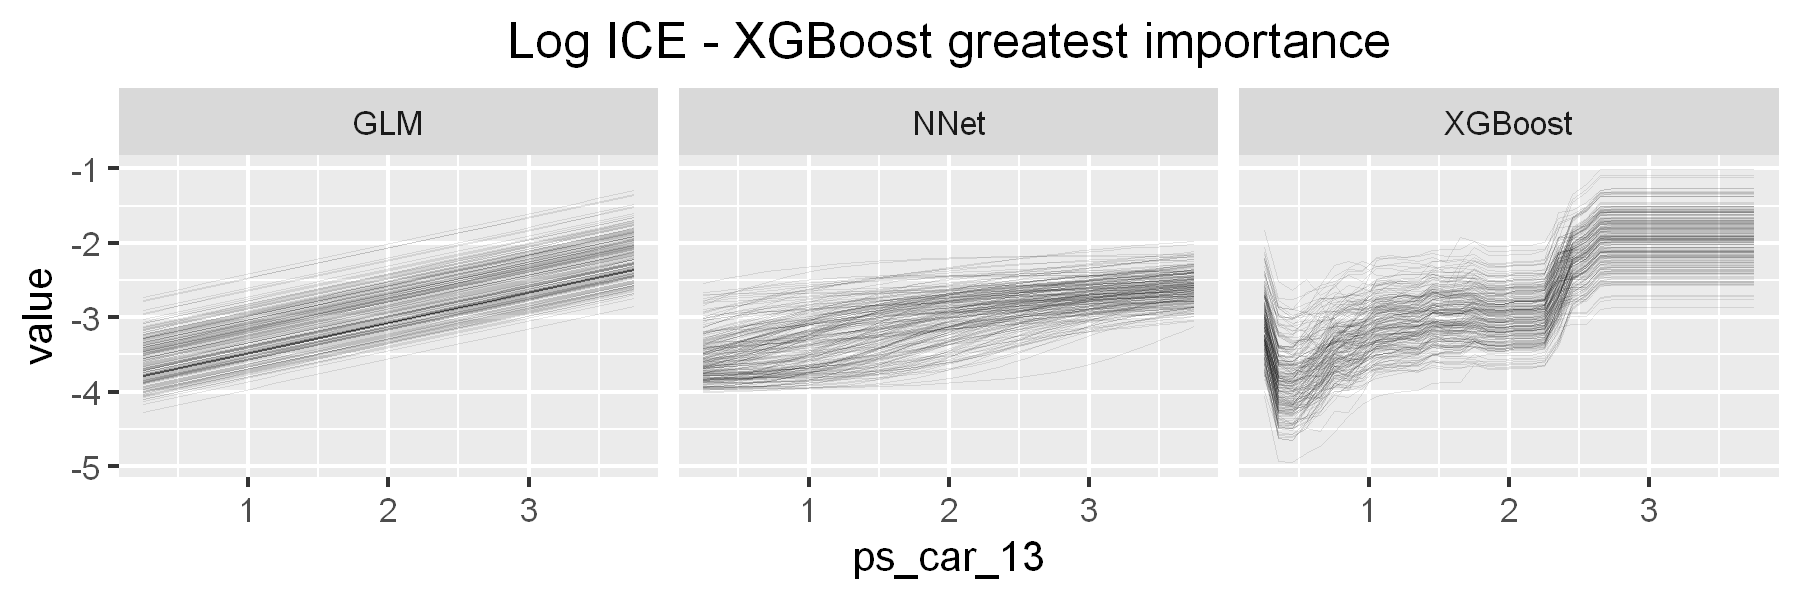

In [126]:
plot(light_ice(fls_log, v = "ps_car_13", n_max = 200, seed = 3), alpha = 0.1) +
  theme_grey(base_size = 25) +
    ggtitle("Log ICE - XGBoost greatest importance") +
    theme(plot.title = element_text(hjust = 0.5))

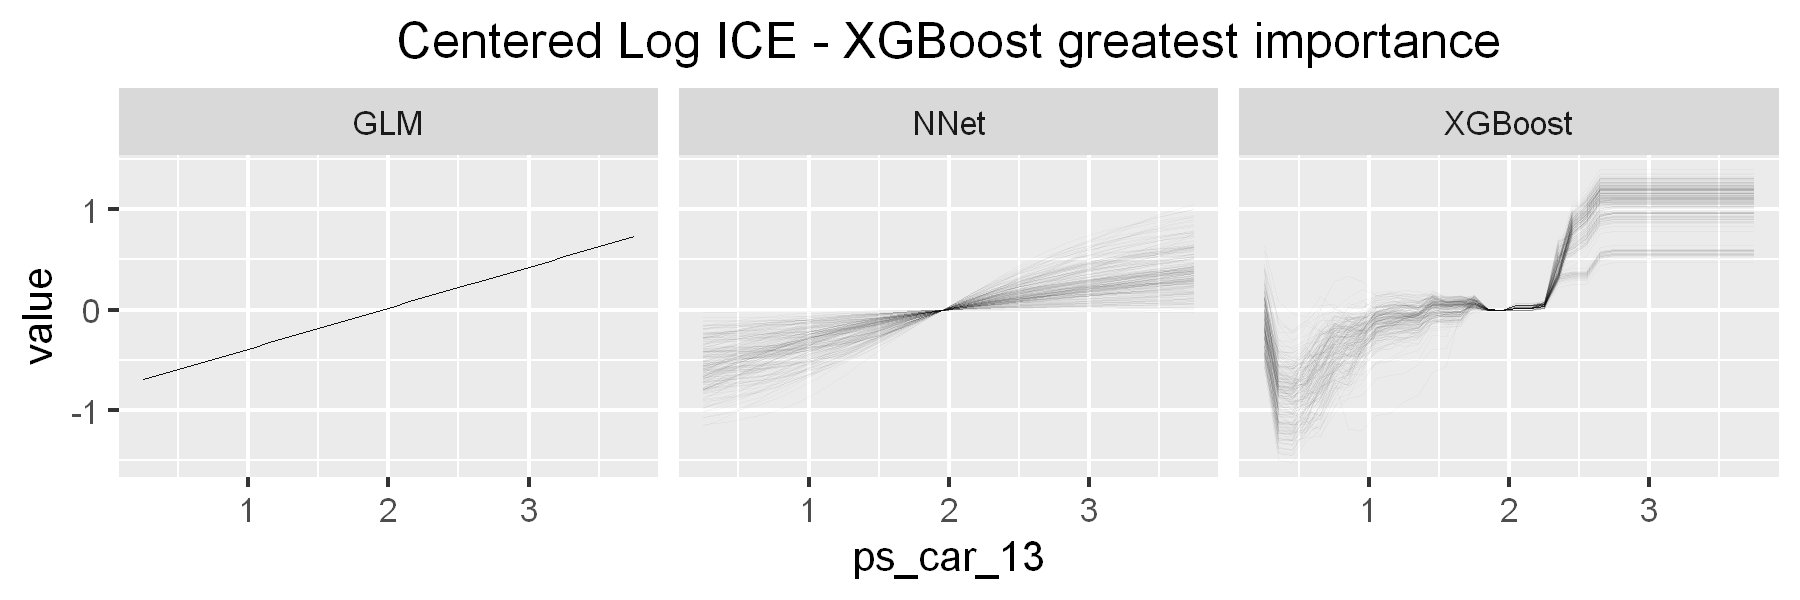

In [127]:
plot(light_ice(fls_log, v = "ps_car_13", n_max = 200, seed = 3, 
               center = "middle"), alpha = 0.03) +
    theme_grey(base_size = 25) +
    ggtitle("Centered Log ICE - XGBoost greatest importance") +
    theme(plot.title = element_text(hjust = 0.5))

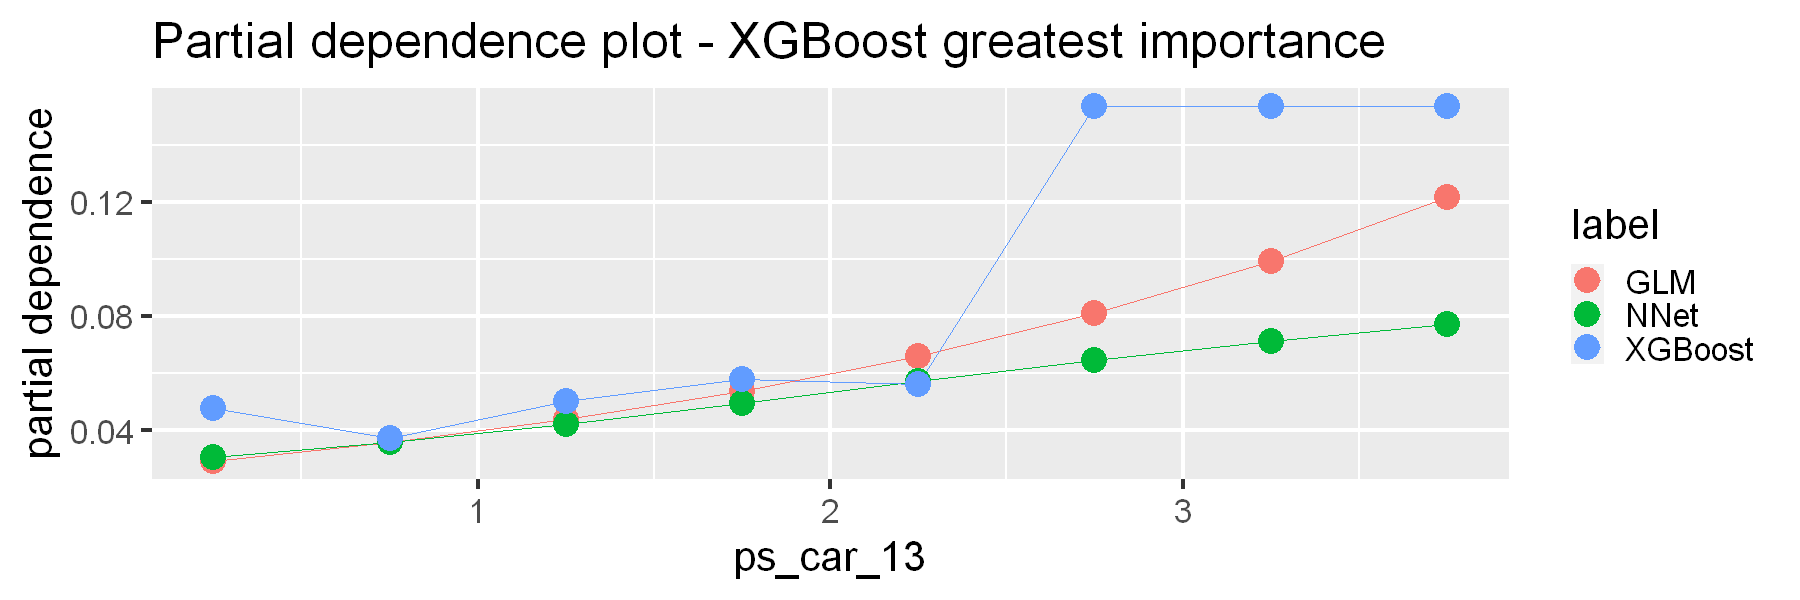

In [151]:
# Partial dependence curves
plot(light_profile(fls, v = "ps_car_13")) +
    theme_grey(base_size = 25) + 
    ggtitle("Partial dependence plot - XGBoost greatest importance")

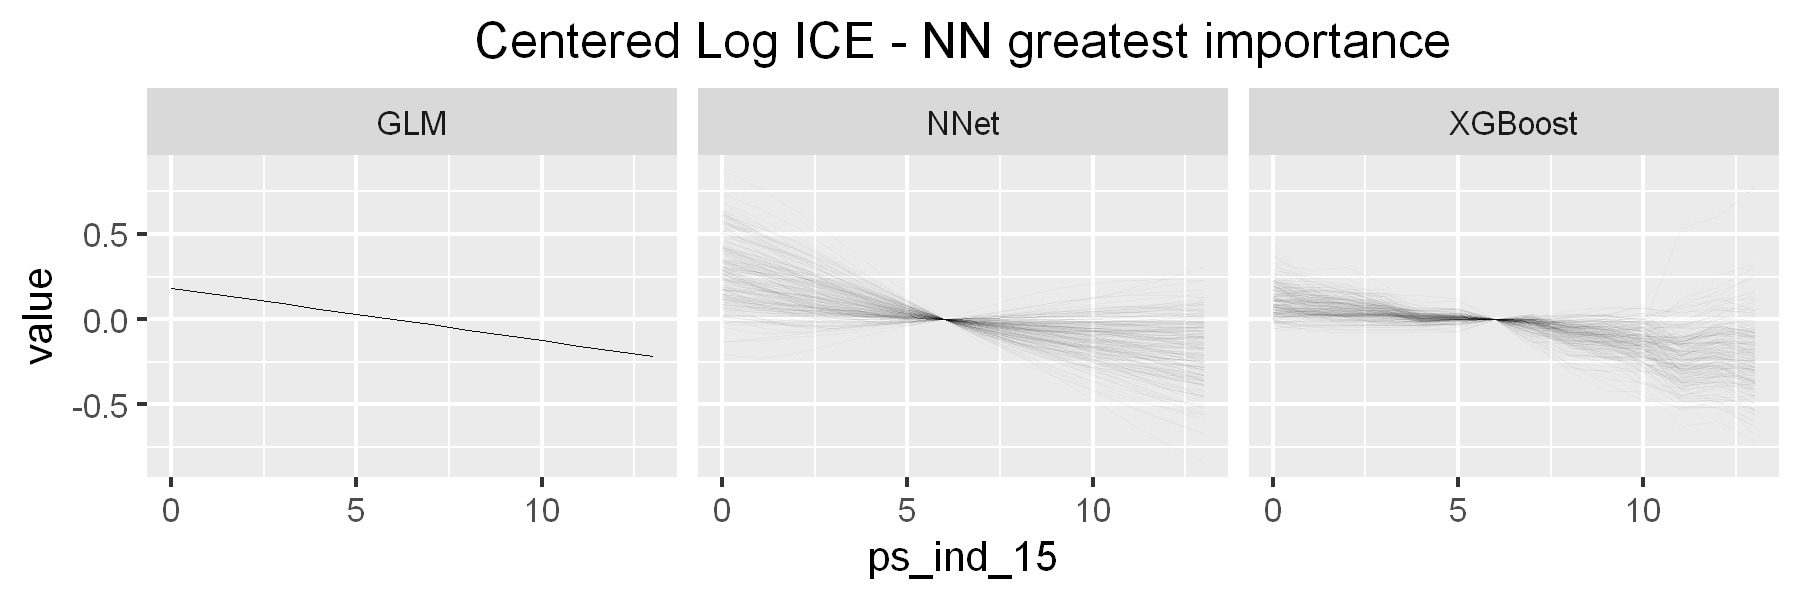

In [130]:
plot(light_ice(fls_log, v = "ps_ind_15", n_max = 200, seed = 3, 
               center = "middle"), alpha = 0.03) +
    theme_grey(base_size = 25) +
    ggtitle("Centered Log ICE - NN greatest importance") +
    theme(plot.title = element_text(hjust = 0.5))

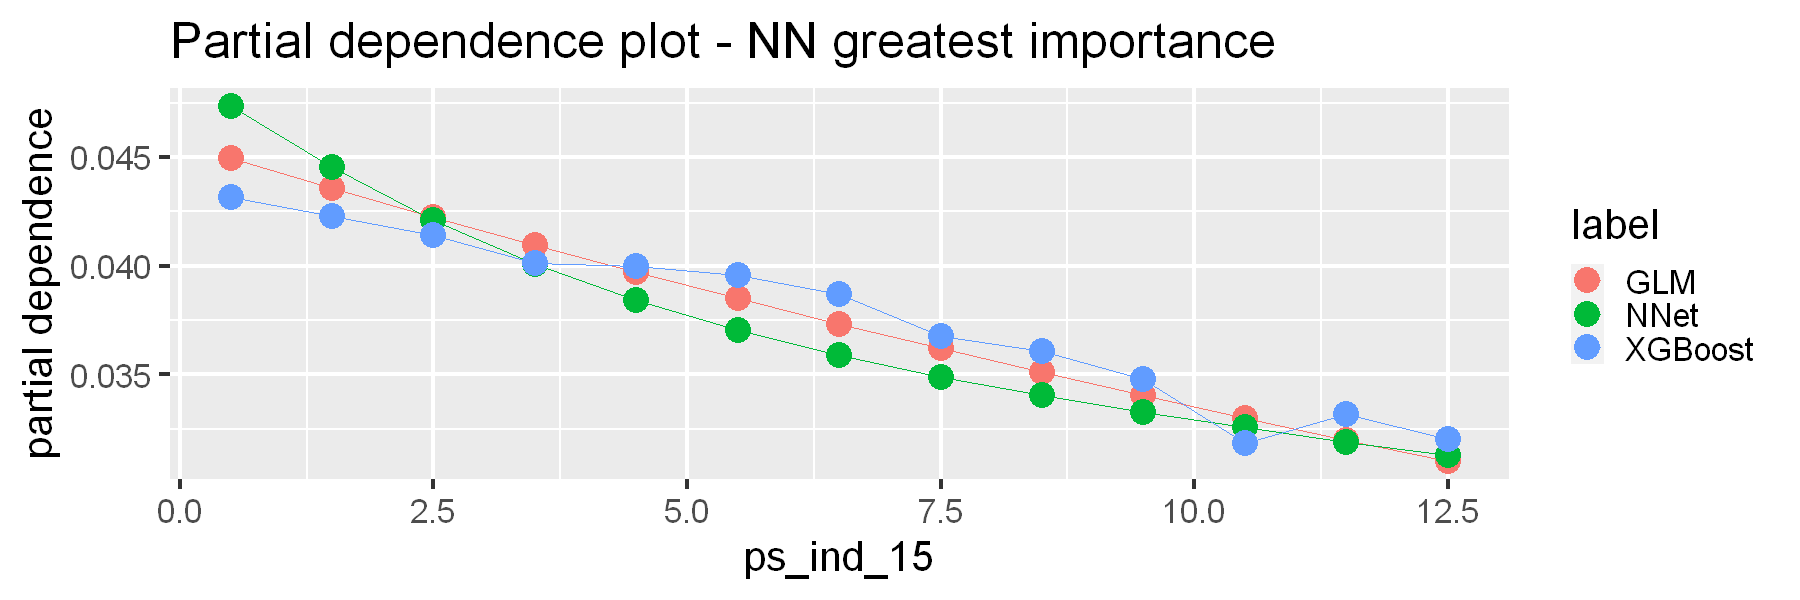

In [149]:
# Partial dependence curves
plot(light_profile(fls, v = "ps_ind_15")) +
    theme_grey(base_size = 25) + 
    ggtitle("Partial dependence plot - NN greatest importance")

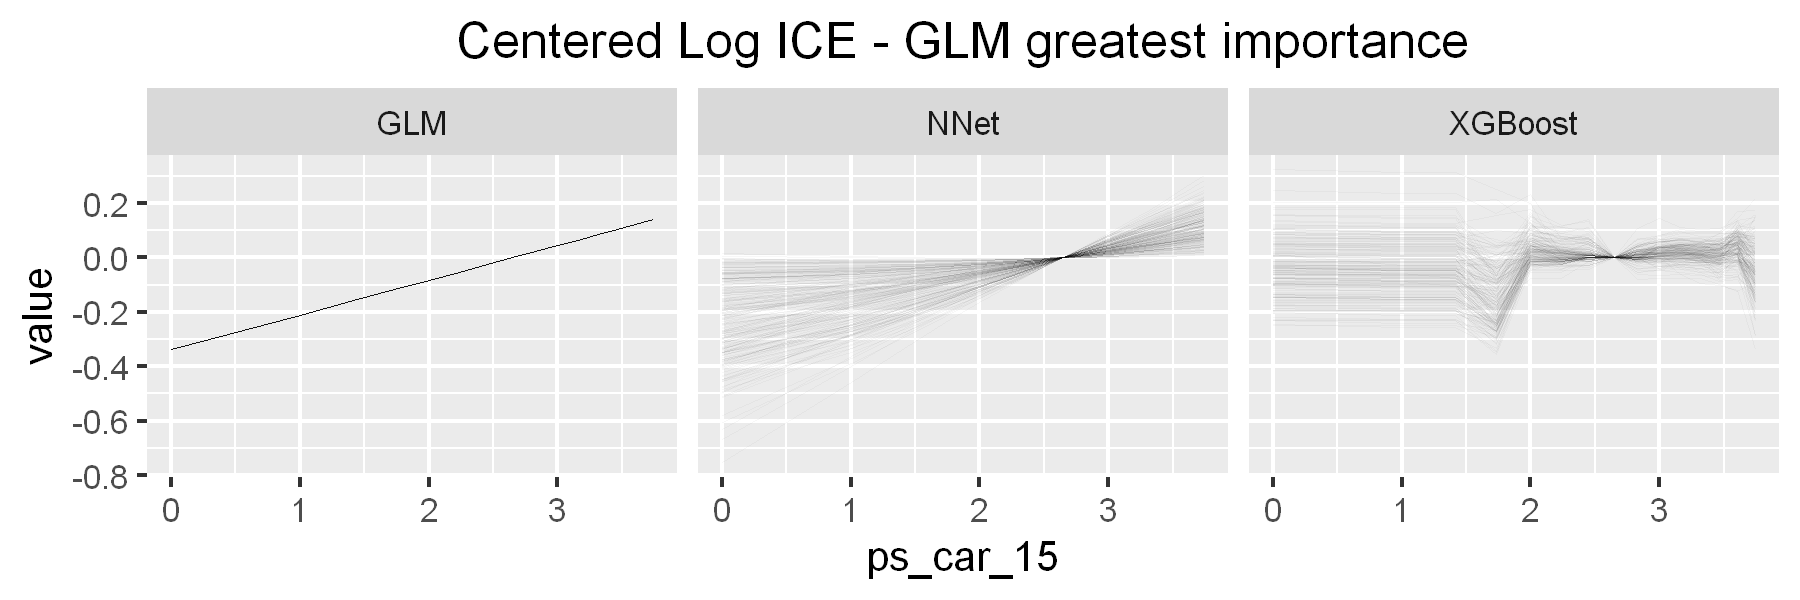

In [132]:
plot(light_ice(fls_log, v = "ps_car_15", n_max = 200, seed = 3, 
               center = "middle"), alpha = 0.03) +
    theme_grey(base_size = 25) +
    ggtitle("Centered Log ICE - GLM greatest importance") +
    theme(plot.title = element_text(hjust = 0.5))

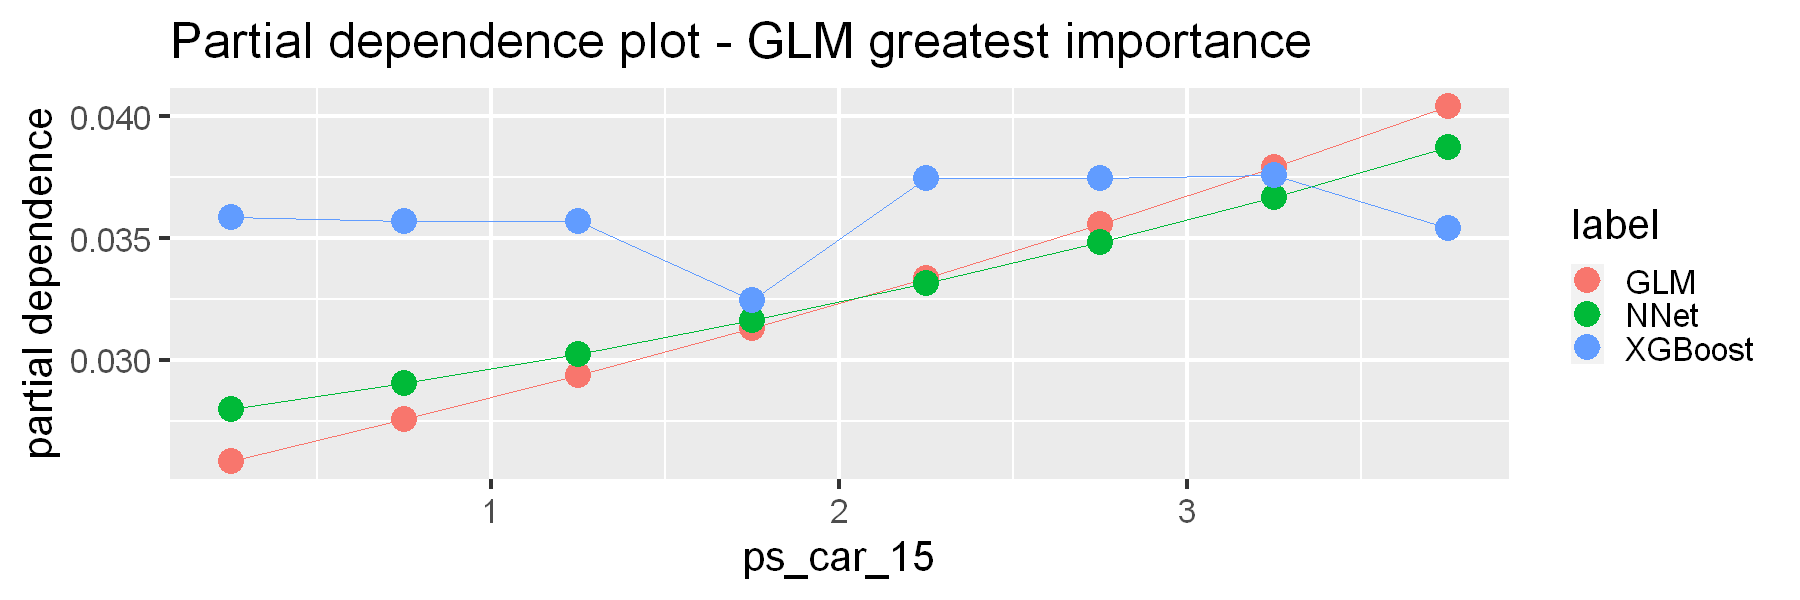

In [146]:
# Partial dependence curves
plot(light_profile(fls, v = "ps_car_15")) +
    theme_grey(base_size = 25) + 
    ggtitle("Partial dependence plot - GLM greatest importance")

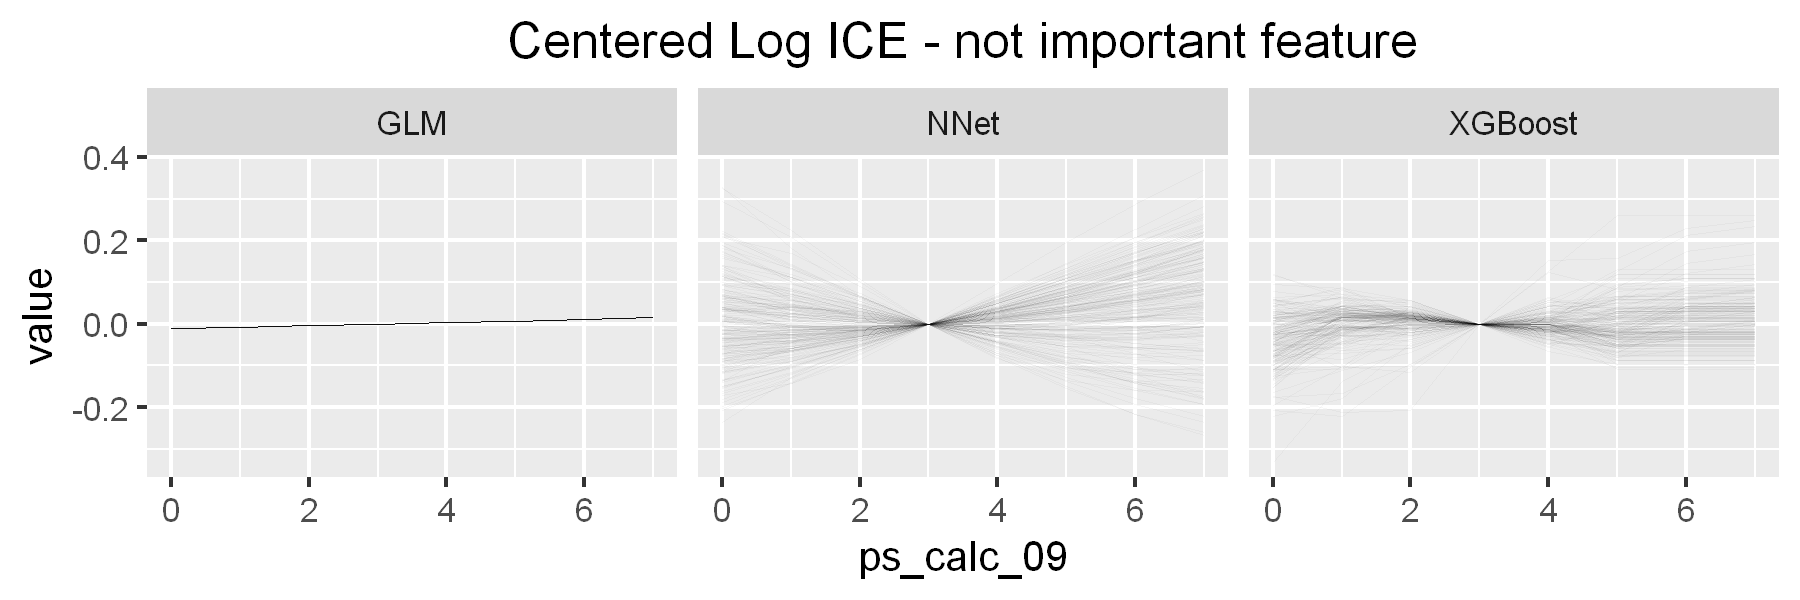

In [134]:
plot(light_ice(fls_log, v = "ps_calc_09", n_max = 200, seed = 3, 
               center = "middle"), alpha = 0.03) +
    theme_grey(base_size = 25) +
    ggtitle("Centered Log ICE - not important feature") +
    theme(plot.title = element_text(hjust = 0.5))

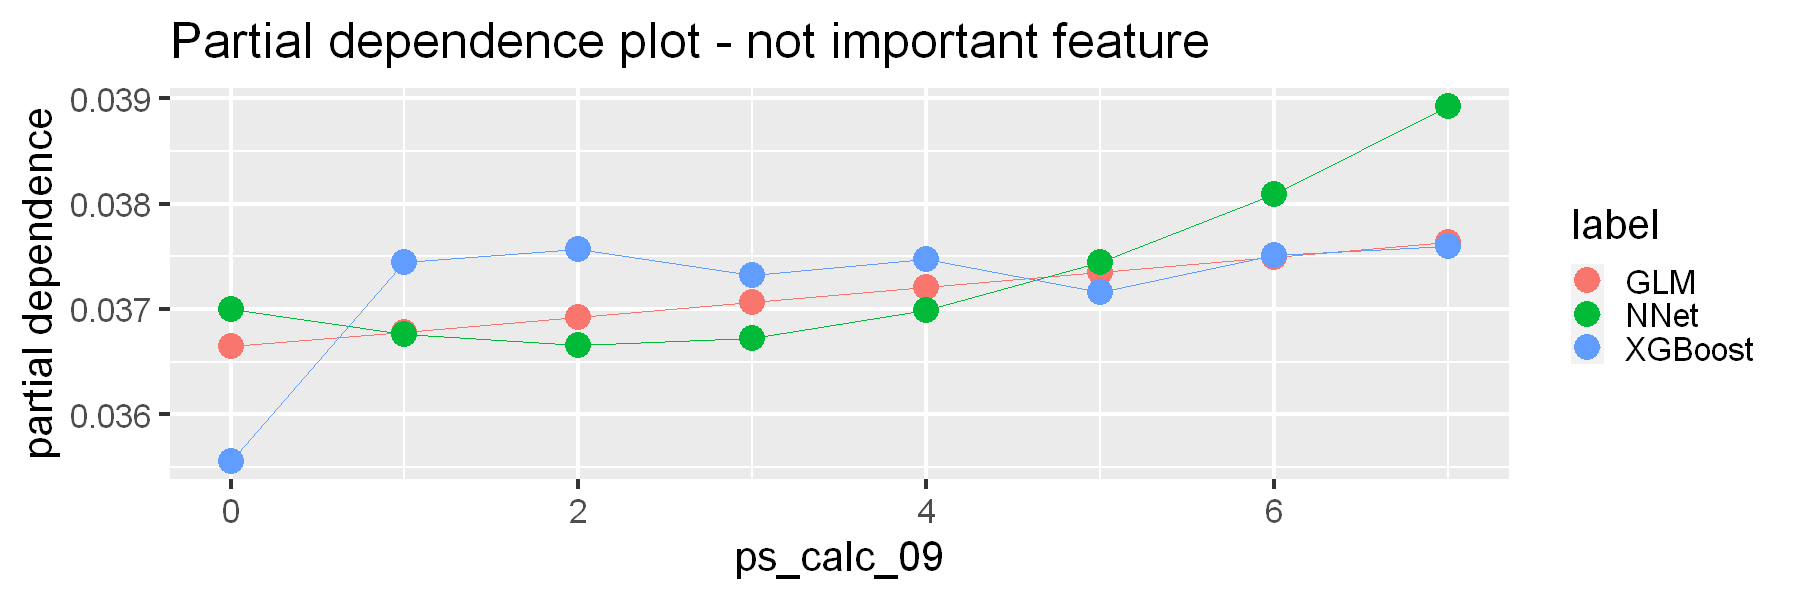

In [142]:
# Partial dependence curves
plot(light_profile(fls, v = "ps_calc_09")) +
    theme_grey(base_size = 25) + 
    ggtitle("Partial dependence plot - not important feature")


In [108]:
odpp_train <- predict(fit_glm, train, type = "response")
odpp_test <- predict(fit_glm, test, type = "response")

odp_xg_tr <- predict(fit_xgb, prep_xgb(train, x))
odp_xg_ts <- predict(fit_xgb, prep_xgb(test, x))

odp_nn_tr <- predict(fit_nn, prep_nn_calib(train, x), type = "response")
odp_nn_ts <- predict(fit_nn, prep_nn_calib(test, x), type = "response")


In [99]:
names(odpp_train) <- NULL
names(odpp_test) <- NULL

In [109]:
mean(odpp_train)
mean(odpp_test)

mean(odp_xg_tr)
mean(odp_xg_ts)

mean(odp_nn_tr)
mean(odp_nn_ts)

[1] 0.03693654

[1] 0.03694313

[1] 0.03693659

[1] 0.03675321

[1] 0.03693654

[1] 0.03692411

In [106]:
mean(train$target)
mean(test$target)

[1] 0.03693654

[1] 0.03632526